# DistilBERT M2 (with class weight)

Importing the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import pathlib
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.metrics import precision_recall_fscore_support, classification_report
import nltk.corpus
from sklearn import metrics
from scipy.special import softmax

import transformers
from transformers import  AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer,TrainerCallback, EarlyStoppingCallback
import glob
from datasets import Dataset

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction   
import copy
from sklearn.utils.class_weight import compute_class_weight
from typing import Optional
from torch import FloatTensor
from torch.nn import BCEWithLogitsLoss

In [2]:
torch.cuda.empty_cache()

## 1. Loading the data

In [4]:
#loading each set into seperate dataframes
folder_path = 'data/clean/'
file_pattern = folder_path + '*.csv'
csv_files = glob.glob(file_pattern)

for csv_file in csv_files:
    if 'train' in csv_file:
        df_train = pd.read_csv(csv_file)
    elif 'val' in csv_file:
        df_val = pd.read_csv(csv_file)
    else:
        df_test = pd.read_csv(csv_file)

In [6]:
df_train.head()

,clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,now if he does off himself everyone will think...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dirty southern wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Model Building

In [6]:
# Sections of config
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.2
MODEL_NAME = 'distilbert-base-uncased'

In [7]:
#Instantiating the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
device

'cuda'

#### Storing all 28 labels into variable target_cols

In [12]:
target_cols = [col for col in df_train.columns if col not in ['clean_text']]

In [13]:
len(target_cols)

28

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

### Tokenization

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
# Tokenize the training set
train_encodings = tokenizer(list(df_train['clean_text']), padding=True, truncation=True, return_tensors='pt')
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': torch.tensor(df_train[target_cols].values, dtype=torch.float32)})

# Tokenize the validation set
val_encodings = tokenizer(list(df_val['clean_text']), padding=True, truncation=True, return_tensors='pt')
valid_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'],
                                 'attention_mask': val_encodings['attention_mask'],
                                 'labels': torch.tensor(df_val[target_cols].values, dtype=torch.float32)})

# Tokenize the test set
test_encodings = tokenizer(list(df_test['clean_text']), padding=True, truncation=True, return_tensors='pt')
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                 'attention_mask': test_encodings['attention_mask'],
                                 'labels': torch.tensor(df_test[target_cols].values, dtype=torch.float32)})

### Model Configurations

In [35]:
# Instantiate the Model
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(target_cols))

In [26]:
#custom callback to get train and validation info during training
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = copy.deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [27]:
# define training args
training_args = TrainingArguments(
    output_dir='data/output/dis/copy/',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_dir="data/output/dis/copy/logs",
    learning_rate=float(LEARNING_RATE),
    weight_decay=0.2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


In [28]:
#Custom function to calculate the metrics for multi label classification
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'recall' : recall_micro,
               'precision': precision_micro,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

#### Compute class weights

In [29]:
# Calculate class weights
num_classes = len(target_cols)
class_counts = np.sum(train_dataset['labels'], axis=0)
class_weights = 1.0 / class_counts

# Normalize weights
class_weights /= class_weights.sum()

In [30]:
class_weights

array([0.00434095, 0.00770108, 0.01144105, 0.00725835, 0.00610007,
       0.01649321, 0.01310535, 0.00818262, 0.02796899, 0.0141389 ,
       0.00886653, 0.02260797, 0.05936463, 0.02101773, 0.03013129,
       0.00673483, 0.23283272, 0.01234719, 0.0085945 , 0.10998846,
       0.01133973, 0.16151459, 0.01615146, 0.11717725, 0.03289563,
       0.01353066, 0.01691332, 0.00126095])

In [41]:
#custom trainer to incorporate class weights
class MultiLabelTrainer(Trainer):
    def __init__(self, *args, class_weights: Optional[FloatTensor] = None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            class_weights = class_weights.to(self.args.device)
            logging.info(f"Using multi-label classification with class weights", class_weights)
        self.loss_fct = BCEWithLogitsLoss(weight=class_weights)

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        try:
            loss = self.loss_fct(outputs.logits.view(-1, model.num_labels), labels.view(-1,model.num_labels))
        except AttributeError:  # DataParallel
            loss = self.loss_fct(outputs.logits.view(-1, model.module.num_labels), labels.view(-1, model.num_labels))

        return (loss, outputs) if return_outputs else loss

In [42]:
# create Trainer instance
trainer = MultiLabelTrainer(
    model_init=model_init,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)
trainer.add_callback(CustomCallback(trainer)) 


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
#start the training
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Recall,Precision,Roc Auc,Accuracy
1,0.092000,0.079645,0.566597,0.447521,0.772012,0.720861,0.428446
1,0.092000,0.087563,0.531300,0.417712,0.729737,0.705465,0.401032
2,0.078500,0.063105,0.684295,0.587490,0.819296,0.790902,0.555451
2,0.078500,0.085009,0.569242,0.483856,0.691223,0.737191,0.450240
3,0.063500,0.045192,0.796230,0.724191,0.884184,0.860014,0.685104
3,0.063500,0.089308,0.576271,0.508934,0.664144,0.748826,0.463140
4,0.048000,0.032261,0.863794,0.809656,0.925691,0.903402,0.771862
4,0.048000,0.099119,0.567211,0.511912,0.635903,0.749532,0.455953
5,0.036100,0.026786,0.891022,0.847427,0.939345,0.922513,0.811233
5,0.036100,0.106081,0.569197,0.525392,0.620971,0.755667,0.461297


TrainOutput(global_step=13565, training_loss=0.06756549691784834, metrics={'train_runtime': 2720.4436, 'train_samples_per_second': 79.781, 'train_steps_per_second': 4.986, 'total_flos': 8202250098919680.0, 'train_loss': 0.06756549691784834, 'epoch': 5.0})

In [44]:
#view train and validation metrics from training
log_history = pd.DataFrame(trainer.state.log_history)
log_history

,loss,learning_rate,epoch,step,train_loss,train_f1,train_recall,train_precision,train_roc_auc,train_accuracy,...,eval_loss,eval_f1,eval_recall,eval_precision,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos
0,0.1615,4.815702e-05,0.18,500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1087,4.631404e-05,0.37,1000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0989,4.447107e-05,0.55,1500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0945,4.262809e-05,0.74,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0920,4.078511e-05,0.92,2500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,1.00,2713,0.079645,0.566597,0.447521,0.772012,0.720861,0.428446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,1.00,2713,NaN,NaN,NaN,NaN,NaN,NaN,...,0.087563,0.531300,0.417712,0.729737,0.705465,0.401032,11.2008,484.431,30.355,NaN
7,0.0861,3.894213e-05,1.11,3000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0801,3.709915e-05,1.29,3500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0808,3.525617e-05,1.47,4000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#store train metrics in dataframe
train_history = log_history[log_history['train_f1'].notna()]
train_history

,loss,learning_rate,epoch,step,train_loss,train_f1,train_recall,train_precision,train_roc_auc,train_accuracy,...,eval_loss,eval_f1,eval_recall,eval_precision,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos
5,NaN,NaN,1.0,2713,0.079645,0.566597,0.447521,0.772012,0.720861,0.428446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,2.0,5426,0.063105,0.684295,0.587490,0.819296,0.790902,0.555451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,3.0,8139,0.045192,0.796230,0.724191,0.884184,0.860014,0.685104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,4.0,10852,0.032261,0.863794,0.809656,0.925691,0.903402,0.771862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,5.0,13565,0.026786,0.891022,0.847427,0.939345,0.922513,0.811233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#store validation metrics in dataframe
val_history = log_history[log_history['eval_f1'].notna()]
val_history

,loss,learning_rate,epoch,step,train_loss,train_f1,train_recall,train_precision,train_roc_auc,train_accuracy,...,eval_loss,eval_f1,eval_recall,eval_precision,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,total_flos
6,NaN,NaN,1.0,2713,NaN,NaN,NaN,NaN,NaN,NaN,...,0.087563,0.531300,0.417712,0.729737,0.705465,0.401032,11.2008,484.431,30.355,NaN
13,NaN,NaN,2.0,5426,NaN,NaN,NaN,NaN,NaN,NaN,...,0.085009,0.569242,0.483856,0.691223,0.737191,0.450240,10.9043,497.603,31.180,NaN
21,NaN,NaN,3.0,8139,NaN,NaN,NaN,NaN,NaN,NaN,...,0.089308,0.576271,0.508934,0.664144,0.748826,0.463140,11.7338,462.424,28.976,NaN
28,NaN,NaN,4.0,10852,NaN,NaN,NaN,NaN,NaN,NaN,...,0.099119,0.567211,0.511912,0.635903,0.749532,0.455953,10.7364,505.384,31.668,NaN
36,NaN,NaN,5.0,13565,NaN,NaN,NaN,NaN,NaN,NaN,...,0.106081,0.569197,0.525392,0.620971,0.755667,0.461297,10.8172,501.609,31.431,NaN


In [47]:
history = pd.merge(train_history, val_history, on='step', how='outer')
history

,loss_x,learning_rate_x,epoch_x,step,train_loss_x,train_f1_x,train_recall_x,train_precision_x,train_roc_auc_x,train_accuracy_x,...,eval_loss_y,eval_f1_y,eval_recall_y,eval_precision_y,eval_roc_auc_y,eval_accuracy_y,eval_runtime_y,eval_samples_per_second_y,eval_steps_per_second_y,total_flos_y
0,NaN,NaN,1.0,2713,0.079645,0.566597,0.447521,0.772012,0.720861,0.428446,...,0.087563,0.531300,0.417712,0.729737,0.705465,0.401032,11.2008,484.431,30.355,NaN
1,NaN,NaN,2.0,5426,0.063105,0.684295,0.587490,0.819296,0.790902,0.555451,...,0.085009,0.569242,0.483856,0.691223,0.737191,0.450240,10.9043,497.603,31.180,NaN
2,NaN,NaN,3.0,8139,0.045192,0.796230,0.724191,0.884184,0.860014,0.685104,...,0.089308,0.576271,0.508934,0.664144,0.748826,0.463140,11.7338,462.424,28.976,NaN
3,NaN,NaN,4.0,10852,0.032261,0.863794,0.809656,0.925691,0.903402,0.771862,...,0.099119,0.567211,0.511912,0.635903,0.749532,0.455953,10.7364,505.384,31.668,NaN
4,NaN,NaN,5.0,13565,0.026786,0.891022,0.847427,0.939345,0.922513,0.811233,...,0.106081,0.569197,0.525392,0.620971,0.755667,0.461297,10.8172,501.609,31.431,NaN


In [48]:
#Plotting function to check for accuracy with graphs 
def plot_model_performance(history):

    #getting train and validation accuracy
    acc = history['train_accuracy_x']
    val_acc = history['eval_accuracy_y']

    #getting train and validation loss
    loss = history['train_loss_x']
    val_loss = history['eval_loss_y']

    epochs_range = range(5)

    plt.figure(figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

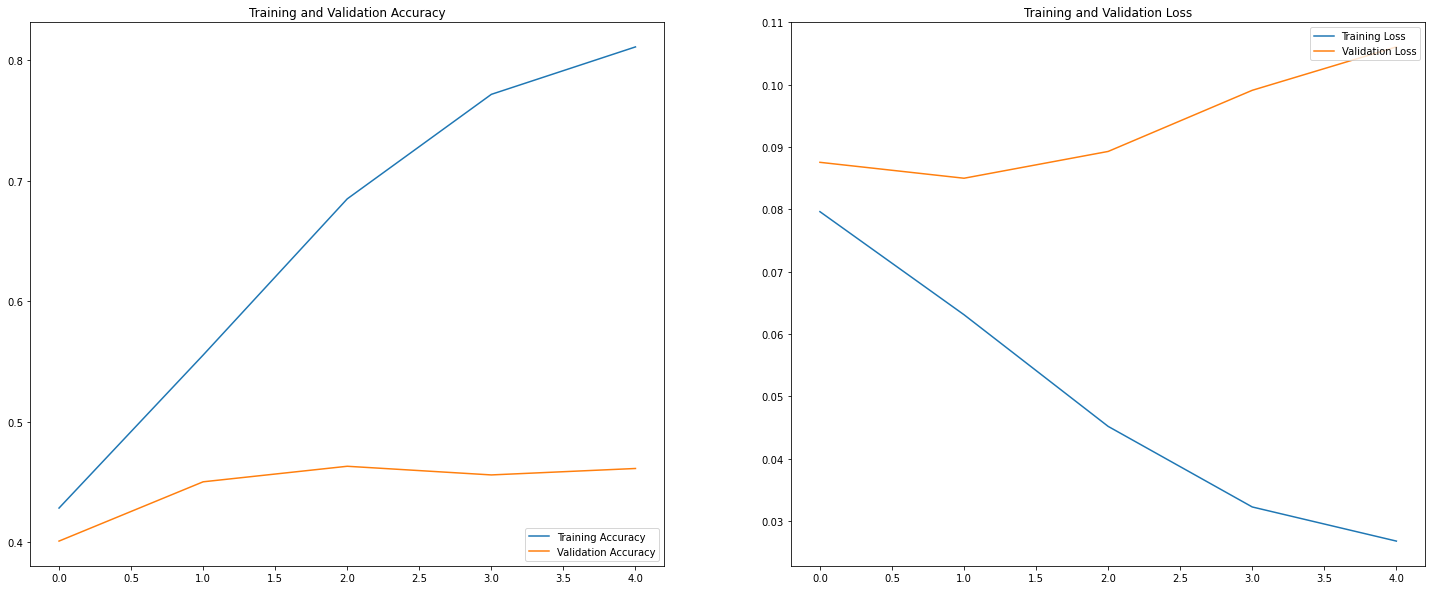

In [49]:
plot_model_performance(history)

## 3. Model Evaluation

In [50]:
#function to evaluate the model on the test set
def evaluate_model(test_dataset):
    test_res = trainer.evaluate(eval_dataset=test_dataset)
    print(test_res)
         
    return trainer.predict(test_dataset)


In [51]:
y_test = evaluate_model(test_dataset)

{'eval_loss': 0.08910774439573288, 'eval_f1': 0.5800035835871709, 'eval_recall': 0.5114552061937114, 'eval_precision': 0.6697703289882061, 'eval_roc_auc': 0.7502478500290867, 'eval_accuracy': 0.46360788649345863, 'eval_runtime': 7.2836, 'eval_samples_per_second': 745.099, 'eval_steps_per_second': 46.68, 'epoch': 5.0}


In [52]:
#function to calculate each emotion label metrics on test set
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [53]:
#function to calculate overall metric on test set
def calc_test_metrics(y_test, test_dataset, target_cols):
    threshold = 0.5
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(y_test.predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= 0.5)] = 1
    
    # finally, compute metrics
    y_true = df_test[target_cols].values
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'recall' : recall_micro,
               'precision': precision_micro,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

    display(metrics_df)
    
    
    results = []
    for label_index, label in enumerate(target_cols):
        y_targets, y_preds = y_true[:, label_index], y_pred[:, label_index]
        results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

    per_label_results = pd.DataFrame(results, index=target_cols)
    display(per_label_results.drop(columns=["label"]).round(3))
    
    return y_true, y_pred


In [54]:
targets, outputs = calc_test_metrics(y_test, test_dataset, target_cols)

,Value
f1,0.580004
recall,0.511455
precision,0.669770
roc_auc,0.750248
accuracy,0.463608


,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.938,0.654,0.708,0.680,0.646,504,0.5
amusement,0.981,0.768,0.864,0.813,0.804,264,0.5
anger,0.966,0.547,0.444,0.490,0.476,198,0.5
annoyance,0.940,0.479,0.219,0.300,0.297,320,0.5
approval,0.937,0.531,0.265,0.354,0.346,351,0.5
caring,0.976,0.544,0.274,0.365,0.376,135,0.5
confusion,0.972,0.509,0.386,0.439,0.429,153,0.5
curiosity,0.950,0.525,0.412,0.462,0.439,284,0.5
desire,0.987,0.688,0.265,0.383,0.422,83,0.5
disappointment,0.974,0.634,0.172,0.271,0.322,151,0.5


In [55]:
# Create a DataFrame to store actual labels and predicted labels
final_df = pd.DataFrame({
    'Actual': [list(np.where(targets[i])[0]) for i in range(len(targets))],
    'Predicted': [list(np.where(outputs[i])[0]) for i in range(len(outputs))]
})

# Map label indices to label names in the 'Actual' column
final_df['Actual'] = final_df['Actual'].apply(lambda indices: [target_cols[idx] for idx in indices])

# Map label indices to label names in the 'Predicted' column
final_df['Predicted'] = final_df['Predicted'].apply(lambda indices: [target_cols[idx] for idx in indices])

# Display the results DataFrame
print("Results DataFrame:")
print(final_df.head(10))

Results DataFrame:
         Actual                Predicted
0     [sadness]                [remorse]
1  [admiration]             [admiration]
2  [excitement]               [optimism]
3   [gratitude]              [gratitude]
4     [neutral]                [neutral]
5   [gratitude]              [gratitude]
6   [gratitude]              [gratitude]
7   [gratitude]  [admiration, gratitude]
8     [remorse]       [remorse, sadness]
9     [sadness]                [sadness]


In [56]:
# Concatenate the label DataFrame with the original DataFramev
val_df_terms = df_test['clean_text']
result_df = pd.concat([val_df_terms, final_df], axis=1)

In [57]:
result_df

,clean_text,Actual,Predicted
0,i am really sorry about your situation frown s...,[sadness],[remorse]
1,it is wonderful because it is awful at not with,[admiration],[admiration]
2,kings fan here good luck to you guys will be a...,[excitement],[optimism]
3,i did not know that thank you for teaching me ...,[gratitude],[gratitude]
4,they got bored from haunting earth for thousan...,[neutral],[neutral]
...,...,...,...
5422,thanks i was diagnosed with bp 1 after the hos...,[gratitude],[gratitude]
5423,well that makes sense,[approval],[approval]
5424,daddy issues name,[neutral],[neutral]
5425,so glad i discovered that subreddit a couple m...,[admiration],[admiration]


## 4. Save the output, tokenizer and model

In [58]:
result_df.to_csv('output__distilbert_M2.csv', index=False, sep=';')

In [59]:
# Save tokenizer
tokenizer.save_pretrained('./distilbert_M2_transformer/')

# Save model
trainer.save_model('./distilbert_M2_transformer/')

In [2]:
import torch
with torch.no_grad():
    torch.cuda.empty_cache()